# Climate Change Belief Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE


from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import string
import re
nltk.download('stopwords')
porterStemmer = nltk.PorterStemmer()
wordNetLemma = nltk.WordNetLemmatizer()
stopword = stopwords.words('english')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Train and Test Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [4]:
train.isnull().values.any()

False

In [5]:
believe = train[train['sentiment'] == 1]
no_belief = train[train['sentiment'] == -1]
neutral = train[train['sentiment'] == 0]
news = train[train['sentiment'] == 2]

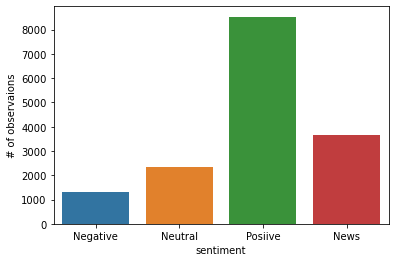

In [6]:
sns.countplot(x = 'sentiment', data = train).set_xticklabels(['Negative','Neutral','Posiive','News'])
plt.ylabel('# of observaions')
plt.show()

In [7]:
print(f"Percentage of Positive tweets: {int(np.round(len(believe)/len(train)*100,0))}%")
print(f"Percentage of Negative tweets: {int(np.round(len(no_belief)/len(train)*100,0))}%")
print(f"Percentage of Neutral tweets: {int(np.round(len(neutral)/len(train)*100,0))}%")
print(f"Percentage of News tweets: {int(np.round(len(news)/len(train)*100,0))}%")

Percentage of Positive tweets: 54%
Percentage of Negative tweets: 8%
Percentage of Neutral tweets: 15%
Percentage of News tweets: 23%


In [ ]:
class_size = int(len(neutral))

In [ ]:
# Upsample mijority and Down sample Majority
no_belief_upsampled = resample(no_belief,
                          replace=True, 
                          n_samples=class_size, 
                          random_state=27) # reproducible results

believe_downsampled = resample(believe,
                          replace=True, 
                          n_samples=len(news),
                          random_state=27)

# Combine downsampled majority class with minority class
sampled_data = pd.concat([no_belief_upsampled, believe_downsampled, neutral, news])

In [ ]:
sampled_data.sentiment.value_counts()

In [ ]:
sns.countplot(x = 'sentiment', data = sampled_data).set_xticklabels(['Negative','Neutral','Positive','News'])
plt.ylabel('# of observaions')
plt.show()

In [ ]:
believe_sampled = sampled_data[sampled_data['sentiment'] == 1]
no_belief_sampled = sampled_data[sampled_data['sentiment'] == -1]
neutral_sampled = sampled_data[sampled_data['sentiment'] == 0]
news_sampled = sampled_data[sampled_data['sentiment'] == 2]

In [ ]:
sampled_data.head()

## Data Cleaning and Text Preprocessing

### Letter casing, Tokenization, Noise removal, Stemming and Lemmatization

In [8]:
def clean_message(message):
    str(message).lower()
    regrex_pattern = re.compile(pattern = "["
      u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
         "]+", flags = re.UNICODE)
    message = regrex_pattern.sub(r'',message) # remove emojis
    # Remove user @ references and '#' from tweet
    message = re.sub(r'@[A-Za-z0-9]+','',message) ##Remove @aderate
    message = re.sub(r'RT[\s]+', '', message) ## remove RT Retweets
    message = re.sub(r'https?:\/\/\S+', '', message) ##remove hyperlink
    message =  ''.join([char for char in message if char not in string.punctuation]) ## remove puntuations i.e. ('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    message = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', '', message) # remove URLs
    message = re.sub(r'@[^\s]+', '', message) # remove usernames
    message = re.sub(r'#[A-Za-z0-9]+', '', message) #get rid of hashtags
    message = message.translate(str.maketrans('', '', string.punctuation))
    message_tokens = word_tokenize(message)
    filtered_message = [word.lower() for word in message_tokens if word not in stopword]

    stemmed_words = [porterStemmer.stem(word) for word in filtered_message]
    lemma_words = [wordNetLemma.lemmatize(word) for word in stemmed_words]

    return ' '.join(lemma_words)

In [9]:
#Clean Data and add new column called cleaned_message
train['message'] = train['message'].apply(clean_message)

In [10]:
train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,it like lack evid anthropogen global warm,126103
2,2,research say three year act climat chang ’ late,698562
3,1,todayinmak wire 2016 pivot year war climat chang,573736
4,1,it 2016 racist sexist climat chang deni bigot ...,466954


In [11]:
X = train['message']
y = train['sentiment']

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words="english")
X_vectorized = vectorizer.fit_transform(X)

oversample = SMOTE()
X, y = oversample.fit_resample(X_vectorized, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({1: 8530, 2: 8530, 0: 8530, -1: 8530})


#### Plot WordCloud

In [ ]:
## plot word cloud (simply most used words in different sentiments)

allMessages = ' '.join([message for message in sampled_data['cleaned_message']])
message_belief = ' '.join(message for message in believe_sampled['cleaned_message'])
message_no_belief = ' '.join(message for message in no_belief_sampled['cleaned_message'])
message_neutral = ' '.join(message for message in neutral_sampled['cleaned_message'])
message_news = ' '.join(message for message in news_sampled['cleaned_message'])

wordCloud_all = WordCloud(max_font_size=50, max_words=100,background_color='black', colormap='Set1',stopwords = STOPWORDS, random_state= 42).generate(allMessages)

wordCloud_belief = WordCloud(max_font_size=50, max_words=100,background_color='black', colormap='Set2' ,stopwords = STOPWORDS,random_state= 42).generate(message_belief)

wordCloud_no_belief = WordCloud(max_font_size=50, max_words=100,background_color='black', colormap='Set3',stopwords = STOPWORDS, random_state= 42).generate(message_no_belief)

wordCloud_neutral = WordCloud(max_font_size=50, max_words=100,background_color='black',stopwords = STOPWORDS, random_state= 42).generate(message_neutral)

wordCloud_news = WordCloud(max_font_size=50, max_words=100,background_color='black',stopwords = STOPWORDS, random_state= 42).generate(message_news)

fig, ax = plt.subplots(5, 1, figsize  = (10,20))

ax[0].imshow(wordCloud_all, interpolation="bilinear")
ax[0].set_title('All messages', fontsize = 30)
ax[0].axis('off')

ax[1].imshow(wordCloud_belief, interpolation="bilinear")
ax[1].set_title('Believe', fontsize = 30)
ax[1].axis('off')

ax[2].imshow(wordCloud_no_belief, interpolation="bilinear")
ax[2].set_title('No Belief', fontsize = 30)
ax[2].axis('off')

ax[3].imshow(wordCloud_neutral, interpolation="bilinear")
ax[3].set_title('Neutral', fontsize = 30)
ax[3].axis('off')

plt.imshow(wordCloud_news, interpolation="bilinear")
plt.title('News', fontsize = 30)
plt.axis('off')
plt.show()

In [12]:
countVectorizer = CountVectorizer(analyzer=clean_message) 
countVector = countVectorizer.fit_transform(train['message'])
print(f'{countVector.shape[0]} Number of tweets has {countVector.shape[1]} words')

15819 Number of tweets has 244 words


## Splitting out the X variable from the target

In [13]:
train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,it like lack evid anthropogen global warm,126103
2,2,research say three year act climat chang ’ late,698562
3,1,todayinmak wire 2016 pivot year war climat chang,573736
4,1,it 2016 racist sexist climat chang deni bigot ...,466954


In [14]:
print(believe.shape, no_belief.shape, neutral.shape, news.shape)

(8530, 3) (1296, 3) (2353, 3) (3640, 3)


## Turning text into something  model can read

In [ ]:
# X = sampled_data['message']
# y = sampled_data['sentiment']


In [ ]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words="english")
# X_vectorized = vectorizer.fit_transform(X)

## Splitting the training data into a training and validation set

In [15]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.3,shuffle=True, stratify=y, random_state=11)

## Training the model and evaluating using the validation set

In [19]:
names = ['Logistic Regression', 'Nearest Neighbors','Decision Tree', 'Random Forest']

In [20]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    # SVC(gamma=1, C=1,kernel='rbf'),Takes Time
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
]

In [21]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)

    print ('... predicting')
    y_pred = clf.predict(X_train)
    y_pred_test = clf.predict(X_val)

    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average='macro')
    recall    = metrics.recall_score(y_train, y_pred,average='macro')

    f1        = metrics.f1_score(y_train, y_pred, average='macro')
    f1_test   = metrics.f1_score(y_val, y_pred_test, average='macro')

    # Save the results to dictionaries
    models[name] = clf
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)

    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])


results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

Fitting Logistic Regression model...
... predicting
... scoring
Fitting Nearest Neighbors model...
... predicting
... scoring
Fitting Decision Tree model...
... predicting
... scoring
Fitting Random Forest model...
... predicting
... scoring


In [22]:
results.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
Logistic Regression,0.924803,0.924937,0.924803,0.924371,0.857476,7.885628
Nearest Neighbors,0.839139,0.865054,0.839139,0.816991,0.734052,0.018963
Decision Tree,0.443393,0.478313,0.443393,0.438509,0.451664,1.591773
Random Forest,0.260049,0.693078,0.260049,0.122167,0.119343,0.239124


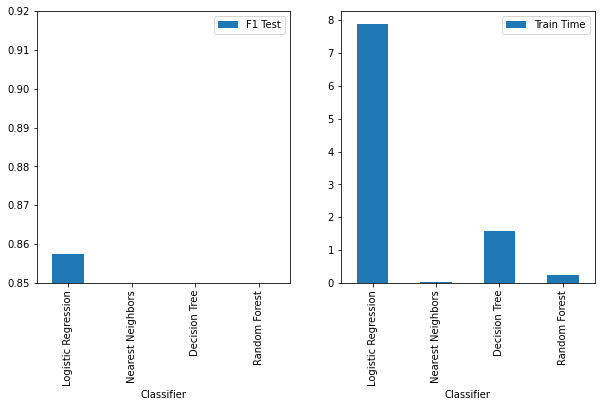

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('F1 Train', ascending=False, inplace=True)
results.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.85,0.92])
results.plot(y='Train Time', kind='bar', ax=ax[1])

In [ ]:
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50]

resultsKnn = []

for k in ks:
    print('Fitting KNN model with k = {:d}'.format(k))
    knn = KNeighborsClassifier(k)
    run_time = %timeit -q -o knn.fit(X_train, y_train)

    # predicting
    y_pred = knn.predict(X_train)
    y_pred_test = knn.predict(X_val)

    # scoring
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average='macro')
    recall    = metrics.recall_score(y_train, y_pred, average='macro')
    f1        = metrics.f1_score(y_train, y_pred, average='macro')
    f1_test   = metrics.f1_score(y_val, y_pred_test, average='macro')

    # save the results 
    resultsKnn.append([k, accuracy, precision, recall, f1, f1_test, run_time.best])

resultsKnn = pd.DataFrame(resultsKnn, columns=['KNN', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
print('Done')

In [ ]:
resultsKnn

In [ ]:
resultsKnn[['F1 Train', 'F1 Test']].plot(kind = 'line', figsize=(10, 8), logx=True)

In [ ]:
param_grid = {'n_neighbors': ks}

In [ ]:
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='f1')

In [ ]:
knn = KNeighborsClassifier(1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_val)

In [ ]:
f1_score(y_val, knn_pred, average="macro")

In [ ]:
 
# defining parameter range 
param_grid = {'C': [0.1, 1],  
              'gamma': [1, 2], 
              'kernel': ['rbf']}  

In [ ]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [ ]:
grid.fit(X_train, y_train)

In [ ]:

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


In [ ]:

grid_predictions = grid.predict(X_val) 

In [ ]:
print(classification_report(y_val, grid_predictions))

### Checking the performance of our model on the validation set

In [35]:
# Training Naive Bayes model
choosen_model_results = []
# Training Logistics Regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

print ('... predicting')
y_pred = lr.predict(X_train)
y_pred_test = lr.predict(X_val)

print ('... scoring')
accuracy  = metrics.accuracy_score(y_train, y_pred)
precision = metrics.precision_score(y_train, y_pred, average='macro')
recall    = metrics.recall_score(y_train, y_pred,average='macro')

f1        = metrics.f1_score(y_train, y_pred, average='macro')
f1_test   = metrics.f1_score(y_val, y_pred_test, average='macro')

choosen_model_results.append([accuracy, precision, recall, f1, f1_test])

results = pd.DataFrame(choosen_model_results, columns=[ 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test'])


... predicting
... scoring


In [36]:
results

,Accuracy,Precision,Recall,F1 Train,F1 Test
0,0.924845,0.924976,0.924845,0.924412,0.857581


In [37]:
metrics.confusion_matrix(y_train, y_pred)

array([[5705,  161,   77,   28],
       [ 109, 5522,  214,  126],
       [ 158,  317, 5107,  389],
       [  23,   56,  137, 5755]], dtype=int64)

In [39]:
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          -1       0.95      0.96      0.95      5971
           0       0.91      0.92      0.92      5971
           1       0.92      0.86      0.89      5971
           2       0.91      0.96      0.94      5971

    accuracy                           0.92     23884
   macro avg       0.92      0.92      0.92     23884
weighted avg       0.92      0.92      0.92     23884



## Getting our test set ready

In [40]:
testx = test['message']
test_vect = vectorizer.transform(testx)

### Making predictions on the test set and adding a sentiment column to our original test df

In [41]:
y_pred = lr.predict(test_vect)

In [42]:
test['sentiment'] = y_pred

In [43]:
test.head()

,message,tweetid,sentiment
0,Europe will now be looking to China to make su...,169760,1
1,Combine this with the polling of staffers re c...,35326,1
2,"The scary, unimpeachable evidence that climate...",224985,1
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,1
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,0


### Creating an output csv for submission

In [44]:
test[['tweetid','sentiment']].to_csv('testsubmission.csv', index=False)

In [30]:
pwd

'c:\\Users\\user\\Documents\\edsa-work\\Classification\\Predict'